# Importing

In [1]:
# ! pip3 install -q kaggle

# ! mkdir ~/.kaggle
# ! cp /home/ignatlegeza/kaggle/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle competitions list
# ! kaggle competitions download -c humpback-whale-identification -p ./data/

# ! unzip -q ./data/test.zip -d ./data/test
# ! unzip -q ./data/train.zip -d ./data/train

In [2]:
import os
import sys
import time
import pickle
from functools import partial
import multiprocessing
import multiprocessing.dummy
num_cores = multiprocessing.cpu_count()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler # Sampler,
cuda = torch.device('cuda')
cpu = torch.device('cpu')

import torchvision
from torchvision import models, transforms

from tqdm import tqdm
from IPython.display import clear_output

gdrive_path = './models_logs/'

In [3]:
labels = pd.read_csv('./data/train.csv')

# labels.head(5)

In [4]:
lblenc = LabelEncoder()

lblenc.fit(labels['Id'])
labels_encoded = lblenc.transform(labels['Id'])
nw_label_enc = lblenc.transform(['new_whale'])[0] # нужно будет в Dataset

labels['Id_enc'] = labels_encoded
labels.head(5)

,Image,Id,Id_enc
0,0000e88ab.jpg,w_f48451c,4786
1,0001f9222.jpg,w_c3d896a,3808
2,00029d126.jpg,w_20df2c5,662
3,00050a15a.jpg,new_whale,0
4,0005c1ef8.jpg,new_whale,0


In [5]:
print('train size: ', labels.shape[0])
print('num of classes: ', lblenc.classes_.shape[0])

train size:  25361
num of classes:  5005


In [6]:
labels_counter = pd.DataFrame(
    {'label': np.unique(labels['Id_enc'], return_counts=True)[0],
     'count': np.unique(labels['Id_enc'], return_counts=True)[1]}
)

labels_counter = labels_counter.sort_values(by='count', ascending=False)
labels_counter = labels_counter.reset_index(drop=True)

labels_counter.head()

,label,count
0,0,9664
1,712,73
2,3029,65
3,3049,62
4,64,61


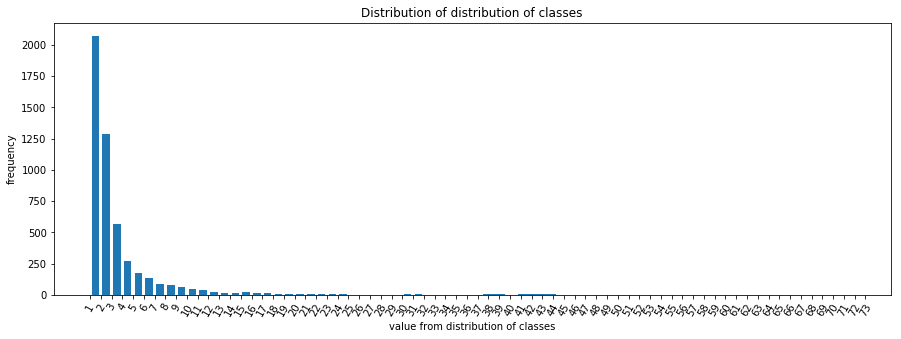

In [7]:
plt.figure(figsize=(15, 5))
plt.hist(labels_counter['count'], 
         bins=np.sort(labels_counter['count'].unique())[:-1], 
         rwidth=0.7)

plt.xticks([x for x in range(1, 74)], rotation=60)
# plt.xticks(np.sort(labels_counter['count'].unique())[:-1], rotation=60)
# plt.xlim(1, 25)
plt.title('Distribution of distribution of classes')
plt.xlabel('value from distribution of classes')
plt.ylabel('frequency')
plt.show()

In [8]:
for i in range(1, 10):
    print(i, '\t', labels_counter[labels_counter['count'] == i].shape[0])

1 	 2073
2 	 1285
3 	 568
4 	 273
5 	 172
6 	 136
7 	 86
8 	 76
9 	 62


# Data clearing

In [9]:
# Изначальные данные:

labels_set_initial = set(labels['Id_enc'])
label_to_indices_initial = {label: np.where(labels['Id_enc'] == label)[0] 
                            for label in labels_set_initial}

In [10]:
# Данные без классов, у которых только одна картинка:
#  (мб выкинуть классы с двумя картиками?)

lonely_labels = []
for key in label_to_indices_initial:
    if len(label_to_indices_initial[key]) == 1:
        lonely_labels.append(key)

labels_without_singles = labels[~labels['Id_enc'].isin(lonely_labels)]
labels_without_singles = labels_without_singles.reset_index(drop=True)

In [11]:
random_state = np.random.RandomState(42)

max_chosen_labels = {
    # len(label imgs): max(chosen imgs)
    1: 0,
    2: int(4500 * 0.15),
    3: int(4500 * 0.05),
    'other': int(4500 * 0.5)
}

current_chosen_labels = {
    0: 0,
    2: 0,
    3: 0,
    'other': 0
}
val_indxs = np.empty(0)
for key in label_to_indices_initial:
    if key == nw_label_enc:
        chosen_indxs = random_state.choice(label_to_indices_initial[key], int(4500*0.3), replace=False)
        val_indxs = np.append(val_indxs, chosen_indxs)
    elif len(label_to_indices_initial[key]) == 2 and \
    current_chosen_labels[2] < max_chosen_labels[2]:
        chosen_indxs = random_state.choice(label_to_indices_initial[key], 1)
        val_indxs = np.append(val_indxs, chosen_indxs)
        current_chosen_labels[2] += 1
    elif len(label_to_indices_initial[key]) == 3 and \
    current_chosen_labels[3] < max_chosen_labels[3]:
        chosen_indxs = random_state.choice(label_to_indices_initial[key], 1)
        val_indxs = np.append(val_indxs, chosen_indxs)
        current_chosen_labels[3] += 1

indxs_to_exclude_for_val = np.empty(0)
indxs_to_exclude_for_val = np.append(indxs_to_exclude_for_val, label_to_indices_initial[0])

labels_with_2_3_imgs = np.array(labels_counter[(labels_counter['count'] >= 1) & 
                                               (labels_counter['count'] <= 3)]['label'])
for label in labels_with_2_3_imgs:
    indxs_to_exclude_for_val = np.append(indxs_to_exclude_for_val, 
                                         label_to_indices_initial[label])

# np.all(np.isin(val_indxs, indxs_to_exclude_for_val))
chosen_indxs = random_state.choice(
    np.array(list(set([*labels.index]) - set(indxs_to_exclude_for_val))), 
    max_chosen_labels['other'], replace=False)
val_indxs = np.append(val_indxs, chosen_indxs)
val_indxs = val_indxs.astype(int)

In [12]:
new_train_indxs = np.array(list(set([*labels.index]) - set(val_indxs)))
new_train_labels_with = labels.iloc[new_train_indxs]
new_train_labels_with = new_train_labels_with.reset_index(drop=True)


labels_set_new = set(new_train_labels_with['Id_enc'])
label_to_indices_new = {label: np.where(new_train_labels_with['Id_enc'] == label)[0] 
                        for label in labels_set_new}

lonely_labels_new = []
for key in label_to_indices_new:
    if len(label_to_indices_new[key]) == 1:
        lonely_labels_new.append(key)

new_train_labels_without = new_train_labels_with[~new_train_labels_with['Id_enc'].isin(lonely_labels_new)]
new_train_labels_without = new_train_labels_without.reset_index(drop=True)

val_labels_df = labels.iloc[val_indxs]
val_labels_df = val_labels_df.reset_index(drop=True)

test_df = os.listdir('./data/test/')
test_df = pd.DataFrame({'Image': test_df})

In [13]:
print(
    'initial labels:', labels.shape, '\n',
    'initial labels without lonelis:', labels_without_singles.shape, '\n',
    'new train labels with lonelis:', new_train_labels_with.shape, '\n',
    'new train labels without lonelis:', new_train_labels_without.shape, '\n',
    'val labels with lonelies:', val_labels_df.shape, '\n',
    'test df:', test_df.shape
)

# new_train_labels_without.groupby('Id_enc').agg('count').groupby('Image').count()

initial labels: (25361, 3) 
 initial labels without lonelis: (23288, 3) 
 new train labels with lonelis: (20861, 3) 
 new train labels without lonelis: (18098, 3) 
 val labels with lonelies: (4500, 3) 
 test df: (7960, 1)


# Datasets, dataloaders, etc.

In [14]:
# %%time
# def res_save(item, source_path_nested, resized_path_nested):
#     im = Image.open(source_path_nested + item)
#     f, _ = os.path.splitext(source_path_nested + item)
#     imResize = im.resize((224, 224), Image.ANTIALIAS)
#     imResize.save(resized_path_nested + item, 'JPEG', quality=95)

# # train resizing
# res_save_item = partial(res_save, 
#                         source_path_nested='./data/train/', 
#                         resized_path_nested='./data/train_resized/')

# ! mkdir ./data/train_resized/
# with multiprocessing.Pool(num_cores) as p:
#     p.map(res_save_item, os.listdir('./data/train/'))

# # test resizing
# res_save_item = partial(res_save, 
#                         source_path_nested='./data/test/', 
#                         resized_path_nested='./data/test_resized/')

# ! mkdir ./data/test_resized/
# with multiprocessing.Pool(num_cores) as p:
#     p.map(res_save_item, os.listdir('./data/test/'))

In [15]:
# WhaleDataset version for model with making triplets after getting embeddings

class WhaleDataset(Dataset):
    def __init__(self, dataset_folder, labels_df, img_loader, transform=None):
        self.dataset_folder = dataset_folder
        self.labels_df = labels_df
        self.transform = transform
        self.img_loader = img_loader
        
        self.image_names = labels_df['Image']
        self.image_labels = labels_df['Id_enc']
    
    def __len__(self):
        return labels_df.shape[0]
    
    def __getitem__(self, index):
#         img = Image.open(self.dataset_folder + self.image_names[index]).convert('RGB')
        img = self.img_loader(self.dataset_folder + self.image_names[index])
        img_label = self.image_labels[index]
        
        if self.transform is not None:
            img = self.transform(img)

        return img, img_label

In [16]:
class WhaleSampler(BatchSampler):
    def __init__(self, labels:np.ndarray, batch_size):
        self.labels = labels
        
        self.labels_unique = np.unique(labels)
        # del nw_class
        self.labels_unique = np.delete(self.labels_unique, 
                                       np.where(self.labels_unique == nw_label_enc)[0])
        # mix (just in case)
        self.labels_unique = np.random.choice(self.labels_unique, 
                                              len(self.labels_unique), 
                                              replace=False)
        self.labels_unique_len = len(self.labels_unique)
        
        self.labels_indxs = np.arange(len(labels))
        self.label_to_indxs = {label: np.where(labels == label)[0] 
                               for label in self.labels_unique}
        
        self.batch_size = batch_size
        self.batch_size_half = batch_size // 2
        
    
    def __iter__(self):
        current_label = self.labels_unique[0]
        while current_label in self.labels_unique:
            batch = []
            
            # batching positives
            batched_positives_num = 0
            while batched_positives_num < self.batch_size_half:
                current_label_indxs = self.label_to_indxs[current_label]
                current_label_indxs_len = len(current_label_indxs)
                
                # get positives from current_label
                if current_label_indxs_len < self.batch_size_half - batched_positives_num:
                    batch.extend(current_label_indxs)
                    
                    batched_positives_num += current_label_indxs_len
                    
                    next_label_pos = np.where(self.labels_unique == current_label)[0][0] + 1
                    if next_label_pos < self.labels_unique_len - 1:
                        current_label = self.labels_unique[next_label_pos]
                    else: 
                        current_label = 1e+6 # only for out from self.labels_unique
                        break
                else:
                    batch.extend(
                        np.random.choice(current_label_indxs, 
                                         self.batch_size_half - batched_positives_num, 
                                         replace=False)
                    )
                    
                    batched_positives_num += self.batch_size_half - batched_positives_num
                    
                    next_label_pos = np.where(self.labels_unique == current_label)[0][0] + 1
                    if next_label_pos < self.labels_unique_len - 1:
                        current_label = self.labels_unique[next_label_pos]
                    else: 
                        current_label = 1e+6 # only for out from self.labels_unique
                        break
                
            # batching negatives
            batch.extend(
                np.random.choice(self.labels_indxs, 
                                 self.batch_size - self.batch_size_half, 
                                 replace=False)
            )
            
            yield batch

In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def imgshow_tensor(img):
    img = img.numpy().transpose((1,2,0))
    img = img * std + mean
    plt.imshow(img)
    plt.grid(False)
    plt.pause(0.01)

In [18]:
class WhaleDataset_val(Dataset):
    def __init__(self, dataset_folder, labels_df, mode='val', transform=None):
        self.dataset_folder = dataset_folder
        self.labels_df = labels_df
        self.image_names = labels_df['Image']
        self.mode = mode
        self.transform = transform
        
        if mode == 'val':
            self.not_nw_indxs = labels_df[labels_df['Id'] != 'new_whale'].index
            self.labels_set = set(labels_df['Id_enc'])
            self.label_to_indices = {label: np.where(labels_df['Id_enc'] == label)[0]
                                     for label in self.labels_set}
            
            random_state = np.random.RandomState(42)
            triplets = [
                [
                    self.image_names[indx],
                    self.image_names[
                        random_state.choice(
                            self.label_to_indices[labels_df['Id_enc'][indx]]
                        )
                    ],
                    self.image_names[
                        random_state.choice(
                            self.label_to_indices[
                                np.random.choice(
                                    list(
                                        self.labels_set - set([labels_df['Id_enc'][indx]])
                                    )
                                )
                            ]
                        )
                    ]
                ]
                for indx in self.not_nw_indxs
            ]
            self.triplets = triplets
    
    def __len__(self):
        if self.mode != 'test':
            return len(self.not_nw_indxs)
        elif self.mode == 'test':
            return self.labels_df.shape[0]
    
    def __getitem__(self, index):
        if self.mode == 'val':
            path1, path2, path3 = self.triplets[index]
            img1 = Image.open(self.dataset_folder + path1).convert('RGB')
            img2 = Image.open(self.dataset_folder + path2).convert('RGB')
            img3 = Image.open(self.dataset_folder + path3).convert('RGB')
            
            if self.transform is not None:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
                img3 = self.transform(img3)
        
            return img1, img2, img3
        
        elif self.mode == 'test':
            img1 = Image.open(self.dataset_folder + self.image_names[index]).convert('RGB')
            
            if self.transform is not None:
                img1 = self.transform(img1)
            
            return img1

# Make preds and metrics calculating

In [19]:
# mAP@5

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l, p in zip(labels, predictions)])

In [20]:
def batch_gen(iterable, batch_size=1):
    l = len(iterable)
    for ndx in range(0, l, batch_size):
        yield iterable[ndx:min(ndx + batch_size, l)]

# def calc_dist(img, train_embdds):
#     diff = img.reshape((-1, 1, 1000)) - train_embdds
#     dist = np.linalg.norm(diff, axis=-1)
#     return dist

class make_preds():
    def __init__(self):
        self.dataset_folders = {'train': None, 'test': None}
        self.label_dfs = {'train': None, 'test': None}
        self.distances = None
        self.len_embdd = None


    def calc_embeddings(self, model, embedding_type,
                       dataset_folder, labels_df, transforms, 
                       batch_size=2**5, num_workers=4):
        assert embedding_type in ['train', 'test'], \
            "embedding_type must be in ['train', 'test']"
        self.dataset_folders.update({embedding_type: labels_df})
        self.label_dfs.update({embedding_type: labels_df})
        
        model.to(cuda)
        model.eval()

        test_dataset = WhaleDataset_val(dataset_folder=dataset_folder, 
                                        labels_df=labels_df, 
                                        mode='test', 
                                        transform=transforms)
        inference_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                       batch_size=batch_size, 
                                                       shuffle=False, 
                                                       num_workers=num_workers)

        embeddings = torch.Tensor().to(cuda)

        for data in tqdm(inference_loader, desc='calc embeddings', position=0):
            data = data.to(cuda)

            with torch.no_grad():        
                embd = model.get_embedding(data)
                embeddings = torch.cat((embeddings, embd))
        
        if embedding_type == 'train':
            self.train_embdds = embeddings
        elif embedding_type == 'test':
            self.test_embdds = embeddings
        
        del test_dataset, inference_loader, data, embeddings


    def get_distances(self, batch_dist_size=20):
        self.num_train_embdds = self.train_embdds.shape[0]
        self.num_test_embdds = self.test_embdds.shape[0]
        self.len_embdd = self.test_embdds.shape[1]
        
        batch_indxs = [*batch_gen(np.arange(self.num_test_embdds), 
                                  batch_size=batch_dist_size)]
        distances = torch.Tensor([]).view((0, self.num_train_embdds)).to(cuda)
        
        for batch in tqdm(batch_indxs, desc='calc distances', position=0):            
            dist = torch.norm((self.test_embdds[batch].view(-1, 1, self.len_embdd) - self.train_embdds), 
                              dim=-1)
            distances = torch.cat((distances, dist))
        
        self.distances = distances.to(cpu).numpy()
        del dist, distances


    def get_preds(self, num_preds=5, agg_func='min'):
        distances = pd.DataFrame(self.distances.T)
        distances['label'] = self.label_dfs['train']['Id_enc'].values
        distances = distances.groupby('label').agg([agg_func]).values

        self.pred_indxs = np.argsort(distances.T)
        pred_labels = np.array([*map(lambda row: lblenc.inverse_transform(row), 
                                     self.pred_indxs[:, 0:num_preds])])

        return pred_labels

# Net architecture & training process

In [31]:
class siamese_net(nn.Module):
    def __init__(self, encoder_net, loss_margin):
        super(siamese_net, self).__init__()
        self.encoder_net = encoder_net
        self.loss_margin = loss_margin
        
    def forward(self, x, labels, size_average=True):
        embeddings = self.encoder_net(x)
        embeddings = embeddings / torch.norm(embeddings, dim=-1).view(-1, 1)
        
#         labels_indxs_out_nw = (labels != nw_label_enc).nonzero().squeeze()
#         embeddings_out_nw = embeddings[labels_indxs_out_nw]
#         labels_with_pos = labels[:batch_size // 2]
        distances = torch.norm(
            (embeddings[:batch_size // 2].view(-1, 1, embeddings.size()[-1]) - embeddings), dim=-1
        )
        
        identities_matrix = labels[:batch_size // 2].view(-1, 1) - labels
        
        # getting distances for hard positives imgs
        identities_mask_pos = identities_matrix == 0
        identities_dist_pos = distances * identities_mask_pos.type(torch.cuda.FloatTensor)
        dist_pos = torch.max(identities_dist_pos, dim=-1)[0]
        
        # getting distances for hard negatives imgs
        identities_mask_neg = identities_matrix != 0
        identities_dist_neg = distances * identities_mask_neg.type(torch.cuda.FloatTensor)
        identities_dist_neg[identities_dist_neg == 0] = 1e+3 # needed just for not to brake min func
        dist_neg = torch.min(identities_dist_neg, dim=-1)[0]
        
        #calc loss
        losses = F.relu(dist_pos - dist_neg + self.loss_margin)
        return losses.mean() if size_average else losses.sum()
        
    def get_embedding(self, x):
        return self.encoder_net(x)
    
    def forward_val(self, x1, x2, x3):
        x1 = self.encoder_net(x1)
        x1 = x1 / torch.norm(x1, dim=-1).view(-1, 1)
        
        x2 = self.encoder_net(x2)
        x2 = x2 / torch.norm(x2, dim=-1).view(-1, 1)
        
        x3 = self.encoder_net(x3)
        x3 = x3 / torch.norm(x3, dim=-1).view(-1, 1)
        
        return x1, x2, x3

In [22]:
# resnet50 = models.resnet50(pretrained=True)

# tst_net = siamese_net(encoder_net=resnet50)
# tst_net.to(cuda)

# for x, labels in tst_train_loader:
#     x, labels = x.to(cuda), labels.to(cuda)
    
#     break

In [23]:
def plot_save_logs(logs, model_name:str, y_lim=2.05, is_plot=True):
    """
    logs example:
    {
        'loss': {
            'train': [1, 1.5, 0.5, 0.3, 0.2],
            'val_y': [0.5, 0.3],
            'val_x': [600, 1200]
        },
        'metrics': {
            'value': [...],
            'epoch': [...]
        }
    }
    
    """
    with open(gdrive_path + model_name + '_logs.pkl', 'wb') as f:
        pickle.dump(logs, f, pickle.HIGHEST_PROTOCOL)
    
    if is_plot == True:
        fig, ax = plt.subplots(2, 1, figsize=(7, 10))

        ax[0].plot(logs['loss']['train'], label='train', zorder=1)
        ax[0].scatter(x=logs['loss']['val_x'], y=logs['loss']['val_y'], label='val', 
                      zorder=2, marker='+', s=180, c='orange')

        ax[0].set(title = 'loss', xlabel='batch num', ylim=(-0.05, y_lim))
        ax[0].legend(loc='best')
        ax[0].grid(True)


        ax[1].scatter(x=logs['metrics']['epoch'], y=logs['metrics']['value'], 
                      marker='+', s=180, c='blue')

        ax[1].set(title = 'mAP', xlabel='epoch num')
        ax[1].grid(True)

        fig.tight_layout()
        plt.show()

In [24]:
def train_model(model, optimizer, train_loader, num_epochs, 
                model_name, margin, val_loader=None): # loss_fn, 
    logs = {
        'loss': {'train': [], 'val_y': [], 'val_x': []},
        'metrics': {'value': [], 'epoch': []}
    }
    
    model.to(cuda)
    for epoch in range(num_epochs):
        # training process
        new_train_sampler = WhaleSampler(labels=new_train_labels_without['Id_enc'].values, 
                                         batch_size=120)
        train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset,
                                           batch_sampler=new_train_sampler,
                                           shuffle=False,
                                           num_workers=7,
                                           pin_memory=True)
        
        model.train()
        for x, labels in tqdm(train_loader, desc='training', position=0):
            optimizer.zero_grad()
            x, labels = x.to(cuda, non_blocking=True), labels.to(cuda, non_blocking=True)
            
            loss = model.forward(x, labels)
            
            loss.backward()
            optimizer.step()
            
            logs['loss']['train'].append(loss.item())
            
            # plot graphs
            clear_output()
            print('\n', 'epoch=', epoch)
            plot_save_logs(logs, model_name, is_plot=True)
            
        # validating process
        if val_loader != None:
            loss_val_batch = []
            model.eval()
            
            # calculating loss
            for data in tqdm(val_loader, desc='validation', position=0):
                with torch.no_grad():
                    data = tuple(d.to(cuda, non_blocking=True) for d in data)

                    outputs = model.forward_val(*data)

                    loss = F.triplet_margin_loss(*outputs, margin=margin).item() # 1
                    loss_val_batch.append(loss)
            
            logs['loss']['val_y'].append(np.mean(loss_val_batch))
            logs['loss']['val_x'].append(len(logs['loss']['train']) - 1)
            
            # calculating metrics
            embedds_preds.calc_embeddings(model=model,
                                          embedding_type='train',
                                          dataset_folder='./data/train_resized/',
                                          labels_df=new_train_labels_with,
                                          transforms=data_transforms)
            embedds_preds.calc_embeddings(model=model,
                                          embedding_type='test',
                                          dataset_folder='./data/train_resized/',
                                          labels_df=val_labels_df,
                                          transforms=data_transforms)
            
            embedds_preds.get_distances(batch_dist_size=10)
            preds = embedds_preds.get_preds()
            mean_ap = map_per_set(val_labels_df['Id'].values.tolist(), preds.tolist())
            
            logs['metrics']['value'].append(mean_ap)
            logs['metrics']['epoch'].append(epoch)
            
            # plot graphs
            clear_output()
            plot_save_logs(logs, model_name, is_plot=True)
        
        # saving model
        state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_path = gdrive_path + model_name + '_state.pth'
        torch.save(state, save_path)

# Net training

In [32]:
resnet50 = models.resnet50(pretrained=False)
# resnet101 = models.resnet101(pretrained=False)

encoder = resnet50

In [33]:
# Encoder modifs

# Modif version 0
# encoder = nn.Sequential(*(list(encoder.children())[:-1]))

# Modif version 1
encoder.fc = nn.Sequential(nn.Linear(2048, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 256)
                          )

# Modif version 2
# encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# encoder.fc = nn.Sequential(nn.Linear(2048, 1024),
#                            nn.ReLU(),
#                            nn.Linear(1024, 256)
#                           )

In [35]:
# training on train set with validation part
pil_imopen = lambda x: Image.open(x).convert('RGB')


new_train_dataset = WhaleDataset(dataset_folder='./data/train_resized/',
                                 labels_df=new_train_labels_without, # new_train_labels_without | val_labels_df
                                 img_loader=pil_imopen,
                                 transform=data_transforms) # data_transforms

new_train_sampler = WhaleSampler(labels=new_train_labels_without['Id_enc'].values, 
                                 batch_size=150)

train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset,
                                           batch_sampler=new_train_sampler,
                                           shuffle=False,
                                           num_workers=10,
                                           pin_memory=True)


val_dataset = WhaleDataset_val(dataset_folder='./data/train_resized/', 
                               labels_df=val_labels_df, 
                               mode='val', 
                               transform=data_transforms)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=38, 
                                         shuffle=False, 
                                         num_workers=10,
                                         pin_memory=True)

In [28]:
# # TEMP_TEMP_TEMP

# enc_resnet_101_cont = siamese_net(encoder_net=resnet101)
# enc_resnet_101_cont.to(cuda)

# optmzr = optim.Adam(enc_resnet_101_cont.parameters(), lr=1e-3)

# state_path = gdrive_path + 'enc_resnet_101' + '_state.pth'
# state = torch.load(state_path)

# enc_resnet_101_cont.load_state_dict(state['model'])
# optmzr.load_state_dict(state['optimizer'])

# del state_path, state

In [29]:
# os.listdir(gdrive_path)

In [30]:
# # test for enc_resnet_50_without_nw_cont0

# train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset, 
#                                            batch_size=batch_size, 
#                                            shuffle=True, 
#                                            num_workers=2,
#                                            pin_memory=True)
# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                          batch_size=batch_size, 
#                                          shuffle=True, 
#                                          num_workers=2,
#                                          pin_memory=True)

In [47]:
# tst = torch.cat([new_train_dataset[0][0].unsqueeze(0), 
#                  new_train_dataset[1][0].unsqueeze(0), 
#                  new_train_dataset[2][0].unsqueeze(0)])
# tst = tst.to(cuda)

# resnet_50_hard_triplets.eval()
# resnet_50_hard_triplets.get_embedding(tst)


 epoch= 5


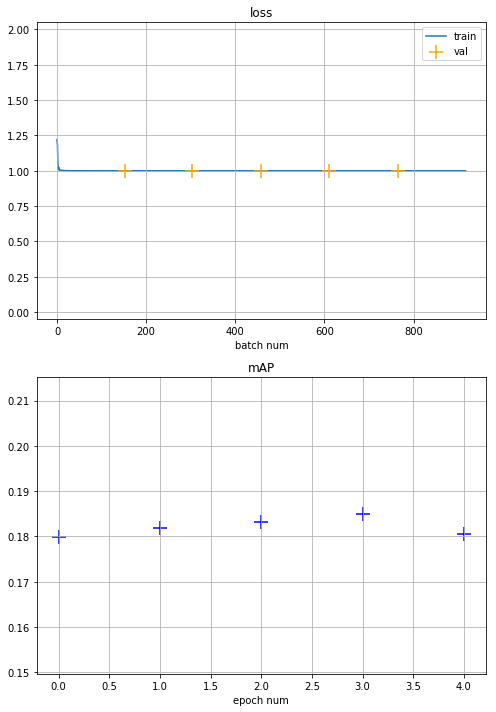

training: 152it [02:14,  1.19it/s]
validation:  55%|█████▌    | 46/83 [00:10<00:07,  4.97it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ignatlegeza/anaconda3/lib/python3.7/multiprocessing/connection

KeyboardInterrupt: 

In [36]:
margin = 1
batch_size = 100

resnet_50_hard_triplets = siamese_net(encoder_net=encoder, loss_margin=margin)

optmzr = optim.Adam(resnet_50_hard_triplets.parameters(), lr=1e-3)

embedds_preds = make_preds()
train_model(model=resnet_50_hard_triplets, optimizer=optmzr, train_loader=train_loader, 
            num_epochs=50, model_name='resnet_50_hard_triplets_mg1_v2', margin=margin, 
            val_loader=val_loader)

In [ ]:
# # training on all train set

# siamese_tst_sub = siamese_net(encoder_net=resnet50)
# # optmzr = optim.Adam(siamese_tst_sub.parameters(), lr=1e-3)

# state_path = gdrive_path + 'sub_margin_06_state.pth'
# state = torch.load(state_path)

# siamese_tst_sub.load_state_dict(state['model'])
# # optmzr.load_state_dict(state['optimizer'])

In [ ]:
# # training on all train set

# train_dataset = WhaleDataset(dataset_folder='./whale/train_resized/', 
#                              labels_df=labels_without_singles, # new_train_labels_without | val_labels_df
#                              mode='train', 
#                              transform=data_transforms)

# batch_size = 32 # 2 ** 5
# # print('batch_size =', batch_size)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=batch_size, 
#                                            shuffle=True, 
#                                            num_workers=3)

# # siamese_tst_sub = siamese_net(encoder_net=resnet50)
# # optmzr = optim.Adam(siamese_tst_sub.parameters(), lr=1e-3)

# train_model(model=enc_resnet_50_without_nw, optimizer=optmzr, train_loader=train_loader, 
#             num_epochs=3, model_name='enc_resnet_50_without_nw_test', val_loader=None)

# Validation or testing

In [ ]:
# resnet50 = models.resnet50(pretrained=True)

# testing_model = siamese_net(encoder_net=resnet50)
# testing_model.load_state_dict(torch.load(gdrive_path + 'enc_resnet_50_without_nw_test_state.pth')['model'])

# testing_model.to(cuda)
# testing_model.eval()
# ;

''

In [ ]:
embedds_preds = make_preds()

In [ ]:
embedds_preds.calc_embeddings(model=testing_model, 
                              embedding_type='train',
                              dataset_folder='./whale/train_resized/', 
                              labels_df=labels, # new_train_labels_with | labels
                              transforms=data_transforms)

embedds_preds.calc_embeddings(model=testing_model, 
                              embedding_type='test',
                              dataset_folder='./whale/test_resized/', # './whale/train/' | /whale/test/
                              labels_df=test_df, # val_labels_df | test_df
                              transforms=data_transforms)

embedds_preds.get_distances(batch_dist_size=20)

calc embeddings: 100%|██████████| 793/793 [03:02<00:00,  4.32it/s]


In [ ]:
preds = embedds_preds.get_preds()

In [ ]:
# preds

In [ ]:
# map_per_set(val_labels_df['Id'].values.tolist(), preds.tolist())

## TSNE train embeddings

In [ ]:
# from sklearn.manifold import TSNE

# train_embdds = embedds_preds.train_embdds.to(cpu).numpy()

# chosen_indxs = np.random.choice(np.arange(len(train_embdds)), size = 1500)
# train_embdds_chosen = train_embdds[chosen_indxs]

# embedds_tsned = TSNE().fit_transform(X=train_embdds_chosen)

''

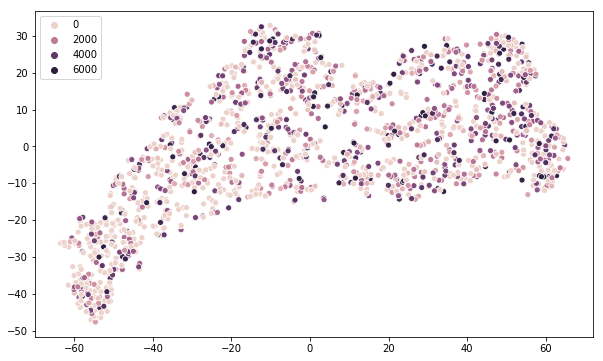

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# sns.scatterplot(embedds_tsned[:, 0], 
#                 embedds_tsned[:, 1], 
#                 labels['Id_enc'][chosen_indxs].values, 
#                 ax=ax)
# ;

# Make submission

In [ ]:
sub = pd.read_csv('./whale/sample_submission.csv')
sub_num = sub.shape[0]

# не провафлить preds
my_preds = pd.DataFrame({'Image': test_df['Image'].values, 
                         'Id': [*map(lambda x: ' '.join(x), preds)]})

sub = sub.drop('Id', axis=1)
sub = pd.merge(sub, my_preds, on='Image')

assert sub.shape[0] == sub_num, \
    'There is something wrong with submission file shape!'

sub.to_csv('/content/whale/submission.csv', index=False)

sub.head(3)

,Image,Id
0,00028a005.jpg,w_9d840d6 w_89ad73e new_whale w_303a3c4 w_48a6027
1,000dcf7d8.jpg,new_whale w_716f64f w_e36b021 w_5c51475 w_307e5e9
2,000e7c7df.jpg,new_whale w_ff7a4ae w_a743e09 w_dc642b6 w_0182687


In [ ]:
# ! kaggle competitions submit -c humpback-whale-identification -f /content/whale/submission.csv -m "enc_resnet_50_without_nw"

# print()
# time.sleep(20)

# ! kaggle competitions submissions -c humpback-whale-identification

100% 498k/498k [00:02<00:00, 220kB/s]
Successfully submitted to Humpback Whale Identification
fileName          date                 description               status    publicScore  privateScore  
----------------  -------------------  ------------------------  --------  -----------  ------------  
submission.csv    2019-02-25 16:01:57  enc_resnet_50_without_nw  complete  0.210        None          
submission_1.csv  2019-02-23 06:34:41  margin 0.6 - 1            complete  0.179        None          
submission.csv    2019-02-22 14:50:33  First sub                 complete  0.207        None          


# TESTS_TESTS

In [ ]:
# # check objects size

# def get_size(obj, seen=None):
#     """Recursively finds size of objects"""
#     size = sys.getsizeof(obj)
#     if seen is None:
#         seen = set()
#     obj_id = id(obj)
#     if obj_id in seen:
#         return 0
#     # Important mark as seen *before* entering recursion to gracefully handle
#     # self-referential objects
#     seen.add(obj_id)
#     if isinstance(obj, dict):
#         size += sum([get_size(v, seen) for v in obj.values()])
#         size += sum([get_size(k, seen) for k in obj.keys()])
#     elif hasattr(obj, '__dict__'):
#         size += get_size(obj.__dict__, seen)
#     elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
#         size += sum([get_size(i, seen) for i in obj])
#     return size

# get_size(embedds_preds) / 1e+6

In [ ]:
# # put train images data into RAM (need ~33gb of RAM)

# train_folder = './whale/train/'
# train_data = {}

# time_start = time.time()
# for num, img_name in enumerate(os.listdir(train_folder)):
#     if num == 5000:
#         break
#     img_load = cv2.imread(train_folder + img_name) # os.path.join(train_folder, img)
#     train_data.update({img_name: img_load})
# time_end = time.time()
# print(time_end - time_start)

# # put test images data into RAM
# # test_folder = './whale/test/'
# # test_data = {}

# # for img_name in os.listdir(test_folder):
# #     img_load = cv2.imread(test_folder + img_name)
# #     test_data.update({img_name: img_load})

In [ ]:
# # try to calc distance
# print('train shape:', embeddings_train_with_lonelies.shape)
# print('val shape:', embeddings_val.shape)


# # first 5 embeddings:
# print('first 5 embeddings shape:', 
#       embeddings_val[0:5, :].reshape((-1, 1, 1000)).shape)

# tst_diff = (embeddings_val[0:5, :].reshape((-1, 1, 1000)) - embeddings_train_with_lonelies)
# print('first 5 embeddings after diff shape:', 
#       tst_diff.shape)

# np.linalg.norm(tst_diff, axis=-1).shape

In [ ]:
# # время расчета разностей всех из трейна со всеми из валидации (in sec.)
# print(4.68 / 1000 * 20861)


# # падает по памяти
# # embeddings_train_with_lonelies[0:5000, :].reshape((-1, 1, 1000)).shape
# # tst = embeddings_train_with_lonelies[0:5000, :].reshape((-1, 1, 1000)) - embeddings_val

# # size of array (2086, 4500, 1000) in GBs
# print(20861 * 4500 * 1000 * 1 / 8e+9)

In [ ]:
# torch.save(siamese_tst.state_dict(), '/gdrive/My Drive/Colab_notebooks/Kaggle/Whales_classification/siamese_tst.pth')

# model = TheModelClass(*args, **kwargs)
# siamese_tst.load_state_dict(torch.load('/gdrive/My Drive/Colab_notebooks/Kaggle/Whales_classification/model_test.pth'))
# model.train() or model.eval()

In [ ]:
# torch.cuda.memory_allocated(cuda)
# torch.cuda.memory_cached(cuda)

In [ ]:
# tst_train_embdds = torch.Tensor(embedds_preds.train_embdds[:1000, :])
# tst_test_embdds = torch.Tenor(embedds_preds.test_embdds)

In [ ]:
# # Dataset previous version

# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# data_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

# class WhaleDataset(Dataset):
#     def __init__(self, dataset_folder, labels_df, 
#                  mode='train', transform=None): # , should_invert=True
#         self.dataset_folder = dataset_folder
# #         self.img_names_list = os.listdir(dataset_folder)
#         self.labels_df = labels_df
#         self.mode = mode
        
#         self.transform = transform
# #         self.should_invert = should_invert

#         if mode == 'train':
#             self.labels_set = set(labels_df['Id_enc'])
#             self.label_to_indices = {label: np.where(labels_df['Id_enc'] == label)[0]
#                                      for label in self.labels_set}
#         elif mode == 'val':
#             self.labels_set = set(labels_df['Id_enc'])
#             self.label_to_indices = {label: np.where(labels_df['Id_enc'] == label)[0]
#                                      for label in self.labels_set}
            
#             random_state = np.random.RandomState(42)
#             triplets = [[indx,
#                          random_state.choice(self.label_to_indices[labels_df.iloc[indx]['Id_enc']]),
#                          random_state.choice(self.label_to_indices[
#                                                  np.random.choice(
#                                                      list(self.labels_set - set([labels_df.iloc[indx]['Id_enc']]))
#                                                  )
#                                              ])
#                         ]
#                         for indx in labels_df.index]
#             self.val_triplets = triplets
# #         elif model == 'test':
            

#     def __len__(self):
#         return self.labels_df.shape[0]
    
#     def __getitem__(self, index):
#         if self.mode == 'train':
# #             start_time = time.time()
# #             img1_path = os.path.join(self.dataset_folder, self.labels_df['Image'][index])
#             img1_path = self.dataset_folder + self.labels_df['Image'][index]
# #             img1 = cv2.imread(img1_path) #.transpose((2, 0, 1))
#             img1 = Image.open(img1_path).convert('RGB')
#             label1 = self.labels_df['Id_enc'][index]
            
#             positive_index = index
#             while positive_index == index:
#                 positive_index = np.random.choice(self.label_to_indices[label1])
#             negative_label = np.random.choice(list(self.labels_set - set([label1])))
#             negative_index = np.random.choice(self.label_to_indices[negative_label])
            
# #             img2_path = os.path.join(self.dataset_folder, self.labels_df['Image'][positive_index])
#             img2_path = self.dataset_folder + self.labels_df['Image'][positive_index]
# #             img2 = cv2.imread(img2_path) #.transpose((2, 0, 1))
#             img2 = Image.open(img2_path).convert('RGB')
            
# #             img3_path = os.path.join(self.dataset_folder, self.labels_df['Image'][negative_index])
#             img3_path = self.dataset_folder + self.labels_df['Image'][negative_index]
# #             img3 = cv2.imread(img3_path) #.transpose((2, 0, 1))
#             img3 = Image.open(img3_path).convert('RGB')
            
# #             print(time.time() - start_time)
        
#         elif self.mode == 'val':
# #             img1_path = os.path.join(self.dataset_folder, self.labels_df['Image'][self.val_triplets[index][0]])
#             img1_path = self.dataset_folder + self.labels_df['Image'][self.val_triplets[index][0]]
#             img1 = cv2.imread(img1_path)
            
# #             img2_path = os.path.join(self.dataset_folder, self.labels_df['Image'][self.val_triplets[index][1]])
#             img2_path = self.dataset_folder + self.labels_df['Image'][self.val_triplets[index][1]]
#             img2 = cv2.imread(img2_path)
            
# #             img3_path = os.path.join(self.dataset_folder, self.labels_df['Image'][self.val_triplets[index][2]])
#             img3_path = self.dataset_folder + self.labels_df['Image'][self.val_triplets[index][2]]
#             img3 = cv2.imread(img3_path)
        
#         elif self.mode == 'test':
# #             img1_path = os.path.join(self.dataset_folder, self.labels_df['Image'][index])
#             img1_path = self.dataset_folder + self.labels_df['Image'][index]
#             img1 = cv2.imread(img1_path)
            
#             if self.transform is not None:
#                 img1 = self.transform(img1)
            
#             return img1
            
#         if self.mode in ['train', 'val']:
#             if self.transform is not None:
#                 img1 = self.transform(img1)
#                 img2 = self.transform(img2)
#                 img3 = self.transform(img3)
        
#             return img1, img2, img3

In [ ]:
# # Class make_preds previous version

# class make_preds():
#     def __init__(self):
#         self.dataset_folders = {'train': None, 'test': None}
#         self.label_dfs = {'train': None, 'test': None}
#         self.distances = None


#     def calc_embeddings(self, model, embedding_type,
#                        dataset_folder, labels_df, transforms, 
#                        batch_size=2**5, num_workers=4):
#         assert embedding_type in ['train', 'test'], \
#             "embedding_type must be in ['train', 'test']"
#         self.dataset_folders.update({embedding_type: labels_df})
#         self.label_dfs.update({embedding_type: labels_df})
        
#         model.to(cuda)
#         model.eval()

#         test_dataset = WhaleDataset(dataset_folder=dataset_folder, 
#                                     labels_df=labels_df, 
#                                     mode='test', 
#                                     transform=transforms)
#         inference_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                                        batch_size=batch_size, 
#                                                        shuffle=False, 
#                                                        num_workers=num_workers)

#         embeddings = torch.Tensor().to(cuda)
# #         embeddings = embeddings.to(cuda)

#         for data in tqdm(inference_loader, desc='calc embeddings', position=0):
#             data = data.to(cuda)

#             with torch.no_grad():        
#                 embd = model.get_embedding(data)
#                 embeddings = torch.cat((embeddings, embd))
        
#         if embedding_type == 'train':
#             self.train_embdds = embeddings #.to(cpu).numpy()
#         elif embedding_type == 'test':
#             self.test_embdds = embeddings #.to(cpu).numpy()
        
#         del test_dataset, inference_loader, data, embeddings


#     def get_distances(self, batch_dist_size=20):
#         self.num_train_embdds = self.train_embdds.shape[0]
#         self.num_test_embdds = self.test_embdds.shape[0]
#         self.len_embdd = self.test_embdds.shape[1]
        
# #         batch_indxs = np.arange(self.num_test_embdds).reshape((-1, minibatch_dist_size))
# #         distances = np.array([]).reshape((0, self.num_train_embdds))
#         batch_indxs = [*batch_gen(np.arange(self.num_test_embdds), 
#                                   batch_size=batch_dist_size)]
#         distances = torch.Tensor([]).view((0, self.num_train_embdds)).to(cuda)
        
#         for batch in tqdm(batch_indxs, desc='calc distances', position=0):
# #             diff = self.test_embdds[batch].reshape((-1, 1, self.len_embdd)) - self.train_embdds
            
# #             dist = np.linalg.norm(diff, axis=-1)
# #             distances = np.concatenate((distances, dist))
            
#             dist = torch.norm((self.test_embdds[batch].view(-1, 1, 1000) - self.train_embdds), 
#                               dim=-1)
#             distances = torch.cat((distances, dist))
# #         map_calc_dist = partial(calc_dist, train_embdds=self.train_embdds)
# #         with multiprocessing.dummy.Pool(num_cores) as pool:
# #             distances = pool.map(map_calc_dist, self.test_embdds)
        
# #         self.distances = np.array(distances).reshape((self.num_test_embdds, 
# #                                                       self.num_train_embdds))
        
#         self.distances = distances.to(cpu).numpy()
#         del distances # diff, dist, 


#     def get_preds(self, num_preds=5, agg_func='min'):
# #         if self.distances is None:
# #             self.get_distances(batch_dist_size)
        
#         distances = pd.DataFrame(self.distances.T)
#         distances['label'] = self.label_dfs['train']['Id_enc'].values
#         distances = distances.groupby('label').agg([agg_func]).values

#         self.pred_indxs = np.argsort(distances.T)
#         pred_labels = np.array([*map(lambda row: lblenc.inverse_transform(row), 
#                                      self.pred_indxs[:, 0:num_preds])])

#         return pred_labels

In [ ]:
# # Loop resizing

# def resize(source_path, resized_path):
#     for item in os.listdir(source_path):
#         im = Image.open(source_path + item)
#         f, _ = os.path.splitext(source_path + item)
#         imResize = im.resize((256, 256), Image.ANTIALIAS)
#         imResize.save(resized_path + item, 'JPEG', quality=95)

# print(os.path.getsize('/content/whale/train/0000e88ab.jpg') / 1e+6)
# print(os.path.getsize('/content/whale/train_resized/0000e88ab.jpg') / 1e+6)

# ! mkdir /content/whale/train_resized/

# resize(source_path='/content/whale/train/', 
#        resized_path='/content/whale/train_resized/')


# # Multiprocessed resizing (not working)
# def resize_mp(source_path, resized_path, num_workers=2):
#     def res_save(item, source_path_nested, resized_path_nested):
#         im = Image.open(source_path_nested + item)
#         f, _ = os.path.splitext(source_path_nested + item)
#         imResize = im.resize((224, 224), Image.ANTIALIAS)
#         imResize.save(resized_path_nested + item, 'JPEG', quality=95)
    
#     res_save_item = partial(res_save, 
#                             source_path_nested=source_path, 
#                             resized_path_nested=resized_path)
    
#     with multiprocessing.Pool(num_workers) as p:
#         p.map(res_save_item, os.listdir(source_path))

# ! mkdir /content/whale/train_resized/

# resize_mp(source_path='/content/whale/train/', 
#           resized_path='/content/whale/train_resized/', 
#           num_workers=num_cores)

In [ ]:
# # freeze model params

# for param in resnet50.parameters():
#     param.requires_grad = False

# for param in resnet50.fc.parameters():
#     param.requires_grad = True

In [ ]:
# # training on train set with validation part

# new_train_dataset = WhaleDataset(dataset_folder='./whale/train_resized/', 
#                                  labels_df=new_train_labels_without, # new_train_labels_without | val_labels_df
#                                  mode='train', 
#                                  transform=data_transforms)
# val_dataset = WhaleDataset(dataset_folder='./whale/train_resized/', 
#                            labels_df=val_labels_df, 
#                            mode='val', 
#                            transform=data_transforms)

# batch_size = 32
# # 32 - good for ResNet50
# # ?? 24 - (around) good for ResNet101

# train_loader = torch.utils.data.DataLoader(dataset=new_train_dataset, 
#                                            batch_size=batch_size, 
#                                            shuffle=True, 
#                                            num_workers=4,
#                                            pin_memory=True)
# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                          batch_size=batch_size, 
#                                          shuffle=True, 
#                                          num_workers=4,
#                                          pin_memory=True)